# Кластеризация
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW02] <ФИО>`, где вместо `<ФИО>` указаны фамилия и имя__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы, а так же применить один из алгоритмов к задаче уменьшения цветности изображения.

In [1]:
from functools import reduce
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque
from typing import NoReturn, Union, List

In [2]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

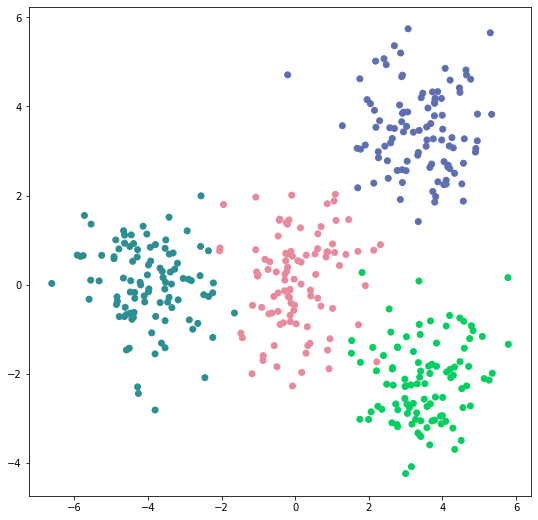

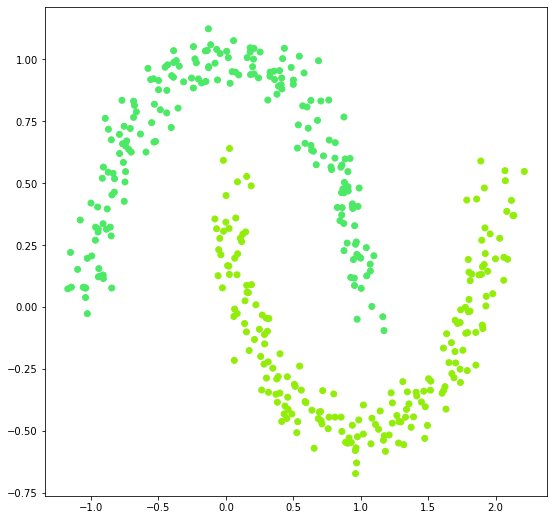

In [3]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 1 (3 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++

__Не забудте реинициализировать пустые кластеры!__

In [4]:
def _fast_dists(X: np.ndarray, Y: np.ndarray) -> np.ndarray:
    return np.sqrt(
        np.sum(np.square(X), axis=1, keepdims=True) +
        np.sum(np.square(Y), axis=1) -
        2 * X @ Y.T +
        1e-8
    )

class KMeans:
    def __init__(self, n_clusters: int, init: str = "random", 
                 max_iter: int = 300):
        """
        
        Parameters
        ----------
        n_clusters : int
            Число итоговых кластеров при кластеризации.
        init : str
            Способ инициализации кластеров. Один из трех вариантов:
            1. random --- центроиды кластеров являются случайными точками,
            2. sample --- центроиды кластеров выбираются случайно из  X,
            3. k-means++ --- центроиды кластеров инициализируются 
                при помощи метода K-means++.
        max_iter : int
            Максимальное число итераций для kmeans.
        
        """
        
        self._n_clusters = n_clusters
        self._init = init
        self._max_iter = max_iter
        self._centroids = None
        self._dists = None
        
    def fit(self, X: np.ndarray, y = None) -> NoReturn:
        """
        Ищет и запоминает в self.centroids центроиды кластеров для X.
        
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit обязаны принимать 
            параметры X и y, даже если y не используется).
        
        """
        self._x = X
        self._init_centroids()

        centroids_for_x = KMeans._get_centroids_for_x(self._dists)
        for _ in range(self._max_iter):
            self._move_centroids(centroids_for_x)
            centroids_for_x_new = KMeans._get_centroids_for_x(self._dists)
            if np.all(centroids_for_x_new == centroids_for_x):
                break
            centroids_for_x = centroids_for_x_new

        del self._dists

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Для каждого элемента из X возвращает номер кластера, 
        к которому относится данный элемент.
        
        Parameters
        ----------
        X : np.array
            Набор данных, для элементов которого находятся ближайшие кластера.
        
        Return
        ------
        labels : np.array
            Вектор индексов ближайших кластеров 
            (по одному индексу для каждого элемента из X).
        
        """
        dists = _fast_dists(self._centroids, X)
        return KMeans._get_centroids_for_x(dists)

    @staticmethod
    def _get_centroids_for_x(dists: np.ndarray) -> np.ndarray:
        return np.argmin(dists, axis=0)

    def _init_centroids(self) -> None:
        if self._init == "random":
            features_min = np.min(self._x, axis=0)
            features_max = np.max(self._x, axis=0)

            self._centroids = np.empty((self._n_clusters, self._x.shape[1]))
            self._dists = np.empty((self._n_clusters, self._x.shape[0]))
            empty = list(range(self._n_clusters))

            while len(empty) != 0:
                new_centroids = np.random.rand(len(empty), self._x.shape[1])
                new_centroids = new_centroids * (features_max - features_min) + features_min
                new_dists = _fast_dists(new_centroids, self._x)

                self._centroids[empty] = new_centroids
                self._dists[empty] = new_dists
                non_empty = set(KMeans._get_centroids_for_x(self._dists))
                empty = [i for i in range(self._n_clusters) if i not in non_empty]

        elif self._init == "sample":
            inds = np.random.choice(self._x.shape[0], size=self._n_clusters, replace=False)
            self._centroids = self._x[inds]
            self._dists = _fast_dists(self._centroids, self._x)

        elif self._init == "k-means++":
            centroids = np.empty((self._n_clusters, self._x.shape[1]))
            dists = np.empty((self._n_clusters, self._x.shape[0]))
            probs = None
            for i in range(self._n_clusters):
                centroids[i] = self._x[np.random.choice(self._x.shape[0], p=probs)]
                dists[i] = np.linalg.norm(self._x - centroids[i], axis=-1)
                weights = np.square(np.min(dists[:i + 1], axis=0))
                probs = weights / weights.sum()
            self._centroids = centroids
            self._dists = dists

    def _move_centroids(self, centroids_for_x: np.ndarray):
        for i in range(self._n_clusters):
            self._centroids[i] = np.mean(self._x[centroids_for_x == i], axis=0)
        self._dists = _fast_dists(self._centroids, self._x)


Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

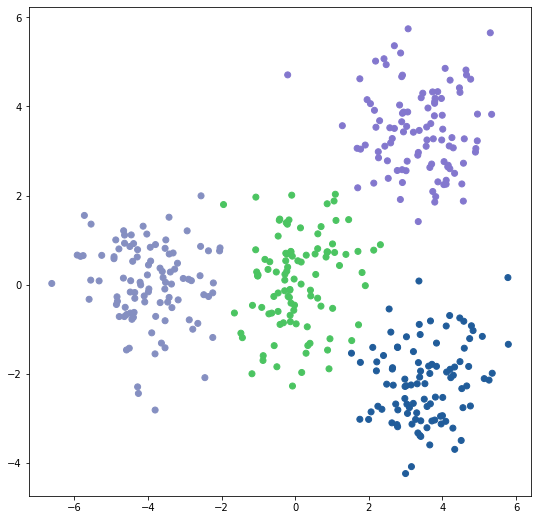

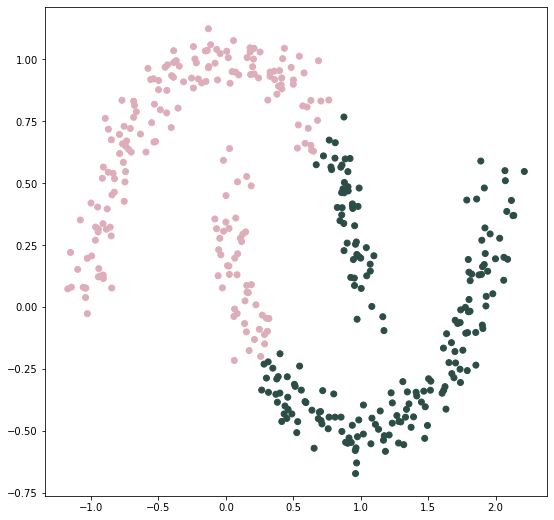

In [5]:
kmeans = KMeans(n_clusters=4, init="random")
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2, init="sample")
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 2 (2 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [6]:
class DBScan:
    def __init__(self, eps: float = 0.5, min_samples: int = 5, 
                 leaf_size: int = 40, metric: str = "euclidean"):
        """
        
        Parameters
        ----------
        eps : float, min_samples : int
            Параметры для определения core samples.
            Core samples --- элементы, у которых в eps-окрестности есть 
            хотя бы min_samples других точек.
        metric : str
            Метрика, используемая для вычисления расстояния между двумя точками.
            Один из трех вариантов:
            1. euclidean 
            2. manhattan
            3. chebyshev
        leaf_size : int
            Минимальный размер листа для KDTree.

        """
        self._eps = eps
        self._min_samples = min_samples
        self._leaf_size = leaf_size
        self._metric = metric
        
    def fit_predict(self, X: np.array, y = None) -> np.array:
        """
        Кластеризует элементы из X, 
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать 
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        kd_tree = KDTree(X, self._leaf_size, metric=self._metric)
        reachable_arr = kd_tree.query_radius(X, self._eps)
        core_points_mask = np.vectorize(len)(reachable_arr) >= self._min_samples
        core_points = np.where(core_points_mask)[0]

        # Reserving 0 for outliers
        labels = np.zeros(X.shape[0], dtype=np.int)

        cur_label = 1
        q = deque()
        next_core_point = core_points[0]
        while True:
            q.append(next_core_point)
            labels[next_core_point] = cur_label
            while q:
                cur_v = q.popleft()
                next_vs = reachable_arr[cur_v]
                q.extend(next_v for next_v in next_vs if labels[next_v] == 0 and core_points_mask[next_v])
                labels[next_vs] = cur_label
            next_core_points_inds = np.where((labels == 0)[core_points])[0]
            if not len(next_core_points_inds):
                break
            next_core_point = core_points[next_core_points_inds[0]]
            cur_label += 1

        # The outside code doesn't work well when there is no outliers and no zeros in labels
        return labels - np.min(labels)

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

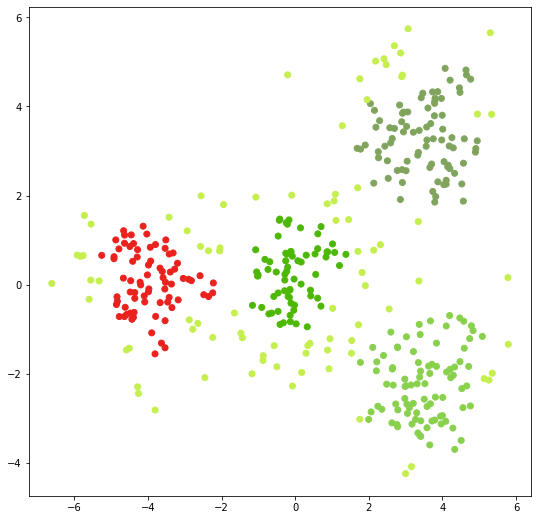

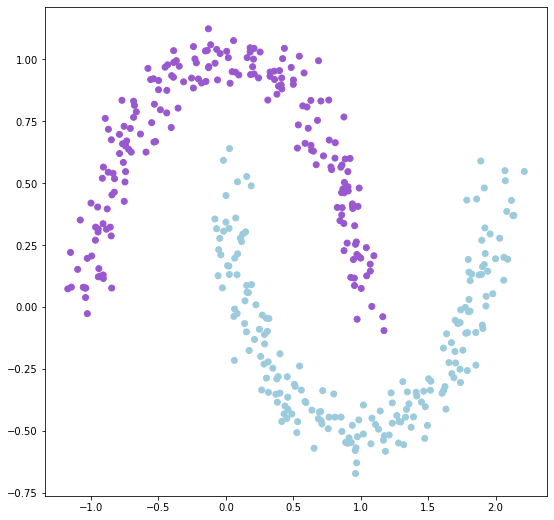

In [7]:
dbscan = DBScan(eps=0.5, min_samples=6)
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(metric="chebyshev", eps=0.2)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 3 (3 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [8]:
class AgglomertiveClustering:
    def __init__(self, n_clusters: int = 16, linkage: str = "average"):
        """
        
        Parameters
        ----------
        n_clusters : int
            Количество кластеров, которые необходимо найти (то есть, кластеры 
            итеративно объединяются, пока их не станет n_clusters)
        linkage : str
            Способ для расчета расстояния между кластерами. Один из 3 вариантов:
            1. average --- среднее расстояние между всеми парами точек, 
               где одна принадлежит первому кластеру, а другая - второму.
            2. single --- минимальное из расстояний между всеми парами точек, 
               где одна принадлежит первому кластеру, а другая - второму.
            3. complete --- максимальное из расстояний между всеми парами точек,
               где одна принадлежит первому кластеру, а другая - второму.
        """
        self._n_clusters = n_clusters
        self._linkage = linkage
        self._x_dists = None
        self._clusters_dists = None
    
    def fit_predict(self, X: np.array, y = None) -> np.array:
        """
        Кластеризует элементы из X, 
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать 
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        self._clusters = [[i] for i in range(X.shape[0])]
        self._x_dists = _fast_dists(X, X)
        self._clusters_dists = self._x_dists.copy()
        self._clusters_dists[range(X.shape[0]), range(X.shape[0])] = float("+inf")

        for _ in range(X.shape[0] - self._n_clusters):
            clusters_to_merge = np.unravel_index(
                np.argmin(self._clusters_dists), self._clusters_dists.shape
            )
            self._merge_clusters(*clusters_to_merge)

        labels = np.zeros(X.shape[0], dtype=np.int) - 1
        cur_cluster = 0
        for cluster in self._clusters:
            if cluster is not None:
                labels[cluster] = cur_cluster
                cur_cluster += 1

        assert np.all(labels != -1)
        assert np.all(labels < self._n_clusters)
        return labels

    def _merge_clusters(self, c1: int, c2: int) -> None:
        new_dists = self._compute_new_cluster_dists(c1, c2)
        self._clusters[c1].extend(self._clusters[c2])
        self._clusters[c2] = None
        self._clusters_dists[c1] = new_dists
        self._clusters_dists[:, c1] = new_dists
        self._clusters_dists[c1, c1] = float("+inf")
        self._clusters_dists[c2] = float("+inf")
        self._clusters_dists[:, c2] = float("+inf")

    def _compute_new_cluster_dists(self, c1: int, c2: int) -> Union[np.ndarray, List[int]]:
        if self._linkage == "single":
            new_dists = np.minimum(self._clusters_dists[c1], self._clusters_dists[c2])
        elif self._linkage == "complete":
            new_dists = np.maximum(self._clusters_dists[c1], self._clusters_dists[c2])
        elif self._linkage == "average":
            new_cluster = self._clusters[c1] + self._clusters[c2]
            new_dists = [
                np.mean(self._x_dists[np.ix_(new_cluster, cluster)])
                if cluster is not None and c != c1 else float("+inf")
                for c, cluster in enumerate(self._clusters)
            ]
        else:
            raise ValueError(f"Unknown linkage {self._linkage}")
        return new_dists

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

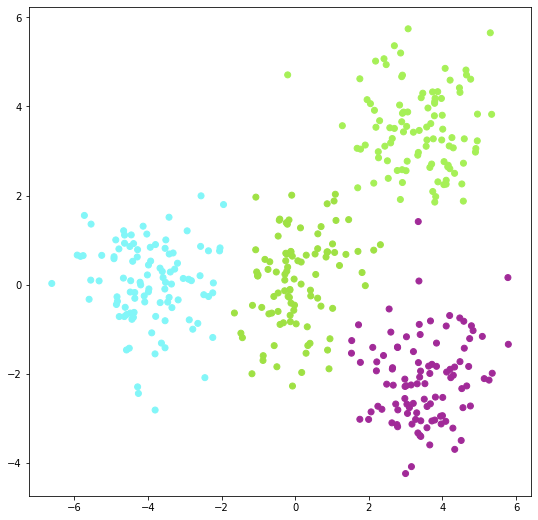

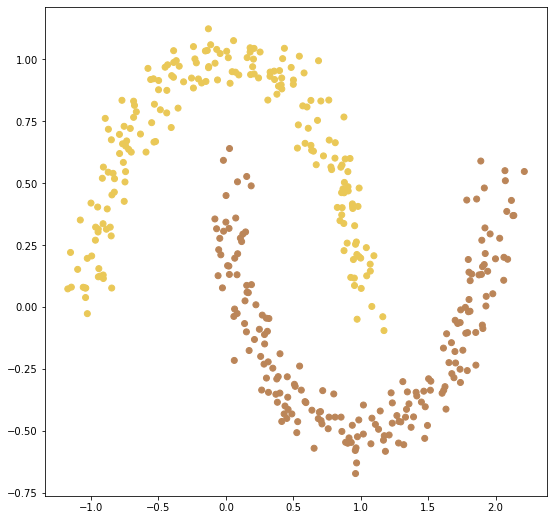

In [9]:
agg_clustering = AgglomertiveClustering(n_clusters=4, linkage="average")
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2, linkage="single")
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 4 (1 балл)
Реализуйте методы считывания и записи изображения при помощи библиотеки OpenCV. 

#### Описание методов
`read_image(path)` читает изображение и возвращает его в виде трехмерного numpy массива размера `(N, M, C)`, где `N` и `M` - размеры изображения, а `C` - количество цветов (3 для обычного изображения)
`save_image(image, path)` сохраняет изображение.

__Учтите, что `cv2.imread` считывает изображение в цветовой схеме BGR. После считывания необходимо перевести его в RGB и нормализовать__

In [10]:
def read_image(path: str) -> np.array:
    """
    Читает изображение.

    Parameters
    ----------
    path : str
        Путь к изображению.
    
    Return
    ------
    image : np.array
        Трехмерный массив размера (N, M, C), 
        где N и M - размеры изображения, 
        а C - количество цветов (3 для обычного изображения).
    """
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    mean, std = np.mean(image, keepdims=True), np.std(image, keepdims=True)
    image = (image - mean) / std
    return image, mean, std

def show_image(image: np.array) -> NoReturn:
    """
    Выводит изображение

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    """
    image, mean, std = image
    image = (image * std + mean).astype(np.uint8)
    plt.figure(figsize=np.array(image.shape[:-1]) / 50)
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_image(image: np.array, path: str) -> NoReturn:
    """
    Сохраняет изображение.

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    path : str
        Путь для сохранения.
    """
    image, mean, std = image
    image = (image * std + mean).astype(np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(path, image)

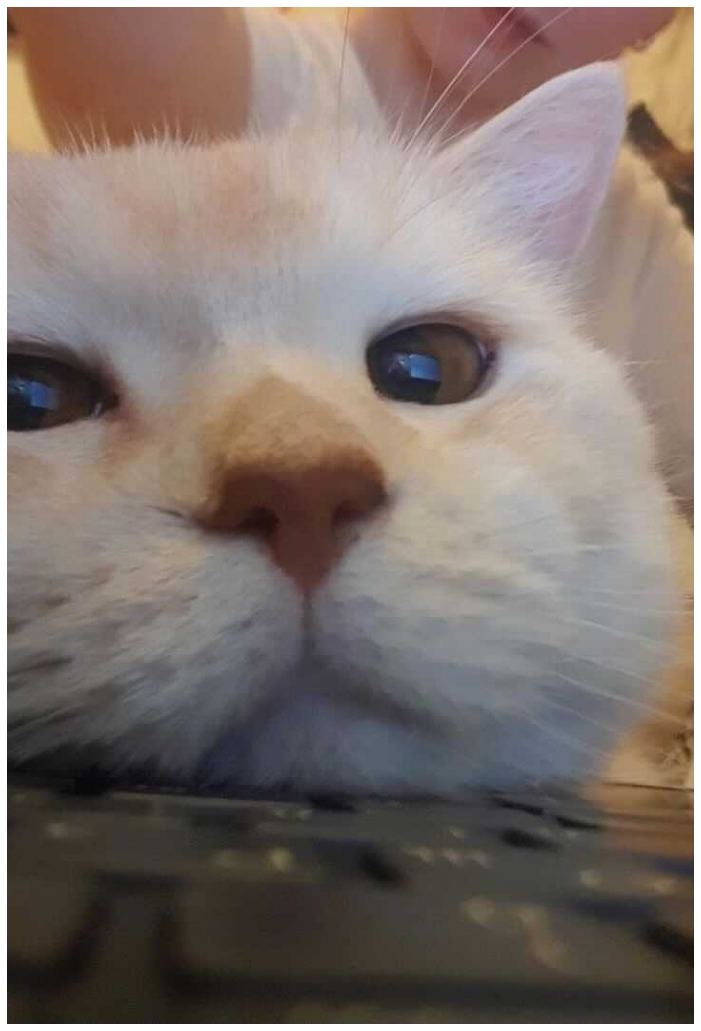

In [11]:
show_image(read_image("./image.jpg"))
save_image(read_image("./image.jpg"), "./image_copy.jpg")

### Задание 5 (1 балл)
Реализуйте функцию, которая будет кластеризовать цвета изображения одним из реализованных алгоритмов. Интерфейс этой функции можно менять. Функция должна возвращать новое изображение, в котором цвета заменены на цвета кластеров.

Затем примените ее к цветам изображения.

__Примечание: это задание проще всего выполнить при помощи KMeans__

In [12]:
def clusterize_image(image, **kwargs):
    image, mean, std = image
    shape = image.shape

    kmeans = KMeans(n_clusters=16, init="k-means++")
    kmeans.fit(image.reshape(-1, 3), None)
    # Cluster labels for each pixel in flattened image
    clusters = kmeans.predict(image.reshape(-1, 3))

    # color of each cluster
    cluster_colors = image.reshape(-1, 3)[np.unique(clusters, return_index=True)[1]]
    # Image with pixel colors assigned to corresponding cluster colors
    recolored = cluster_colors[clusters].reshape(shape)

    # Я наверное не понял, как нужно делать нормализацию
    # cv2.normalize даёт какой-то необратимый результат
    # clusters_statistics(image.reshape(-1, 3), cluster_colors, clusters) # Very slow (:
    return recolored, mean, std

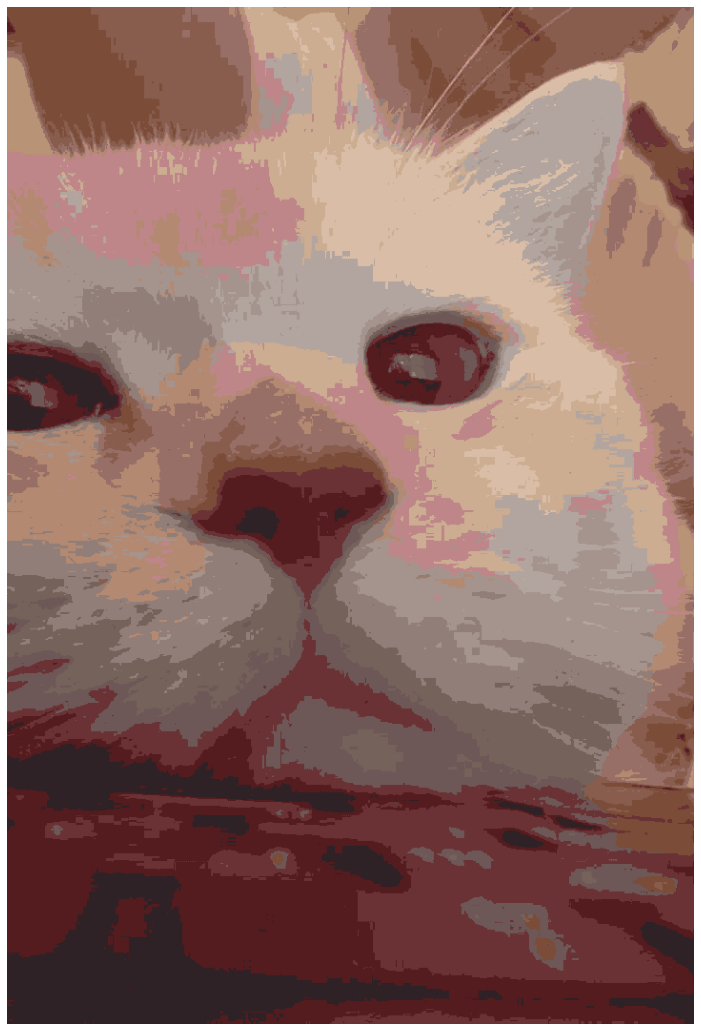

In [13]:
image = read_image("./image.jpg")
result = clusterize_image(image)
show_image(result)
save_image(result, "result.jpg")